In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

print(tf.__version__)

2023-10-11 15:44:17.623695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 15:44:18.276674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [3]:
import keras_tuner as kt
from datetime import datetime

In [4]:
from eggman.grid import luminosity, log_surface_gravity, calculate_eep

In [5]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"
tracks = pd.read_hdf(filename, "tracks")
tracks.head()

star_mass     Yinit     Zinit      amlt  fov_core  fov_shell
track                                                              
7000     0.92329  0.279311  0.001829  1.608258  0.000000   0.006041
7001     1.72329  0.229311  0.010871  2.308258  0.012396   0.006041
7002     2.12329  0.304311  0.004172  2.658258  0.015861   0.006041
7003     1.32329  0.254311  0.024469  1.958258  0.002481   0.006041
7004     1.12329  0.291811  0.006519  2.133258  0.000000   0.006041

In [6]:
stars = pd.read_hdf(filename, "stars")
stars.head()

star_age    radius         Teff  center_h1    log_LHe  \
track star                                                              
7000  1     2.220454e+07  0.893151  6382.509287   0.718192 -45.291905   
      2     2.300916e+07  0.891027  6377.312552   0.718122 -45.308912   
      3     2.397470e+07  0.890320  6373.785487   0.718037 -45.328570   
      4     3.019433e+07  0.893682  6371.412400   0.717474 -45.392646   
      5     3.259691e+07  0.894573  6371.453759   0.717253 -45.402736   

            log_Lnuc  Dnu_freq_o     eps_o  delta_Pg  
track star                                            
7000  1     0.078416  148.565794  1.129515       0.0  
      2     0.077135  149.148739  1.131800       0.0  
      3     0.075916  149.362908  1.132830       0.0  
      4     0.075178  148.552167  1.130613       0.0  
      5     0.075810  148.331713  1.129892       0.0

In [7]:
grid = tracks.join(stars).reset_index()
grid.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius         Teff  center_h1    log_LHe  log_Lnuc  \
0  2.220454e+07  0.893151  6382.509287   0.718192 -45.291905  0.078416   
1  2.300916e+07  0.891027  6377.312552   0.718122 -45.308912  0.077135   
2  2.397470e+07  0.890320  6373.785487   0.718037 -45.328570  0.075916   
3  3.019433e+07  0.893682  6371.412400   0.717474 -45.392646  0.075178   
4  3.259691e+07  0.894573  6371.453759   0.717253 -45.402736  0.075810   

   Dnu_freq_o     eps_o  delta_Pg  
0  148.565794  1.129515       0.0  
1  149.148739  1.131800       0.0  
2  149.362908  1.132830       0.0  
3  148.552167  1.130613       0.0  
4  148.331713  1.129892       0.0

In [8]:
grid["log_Zinit"] = np.log10(grid.Zinit)
grid["log_age"] = np.log10(grid.star_age)

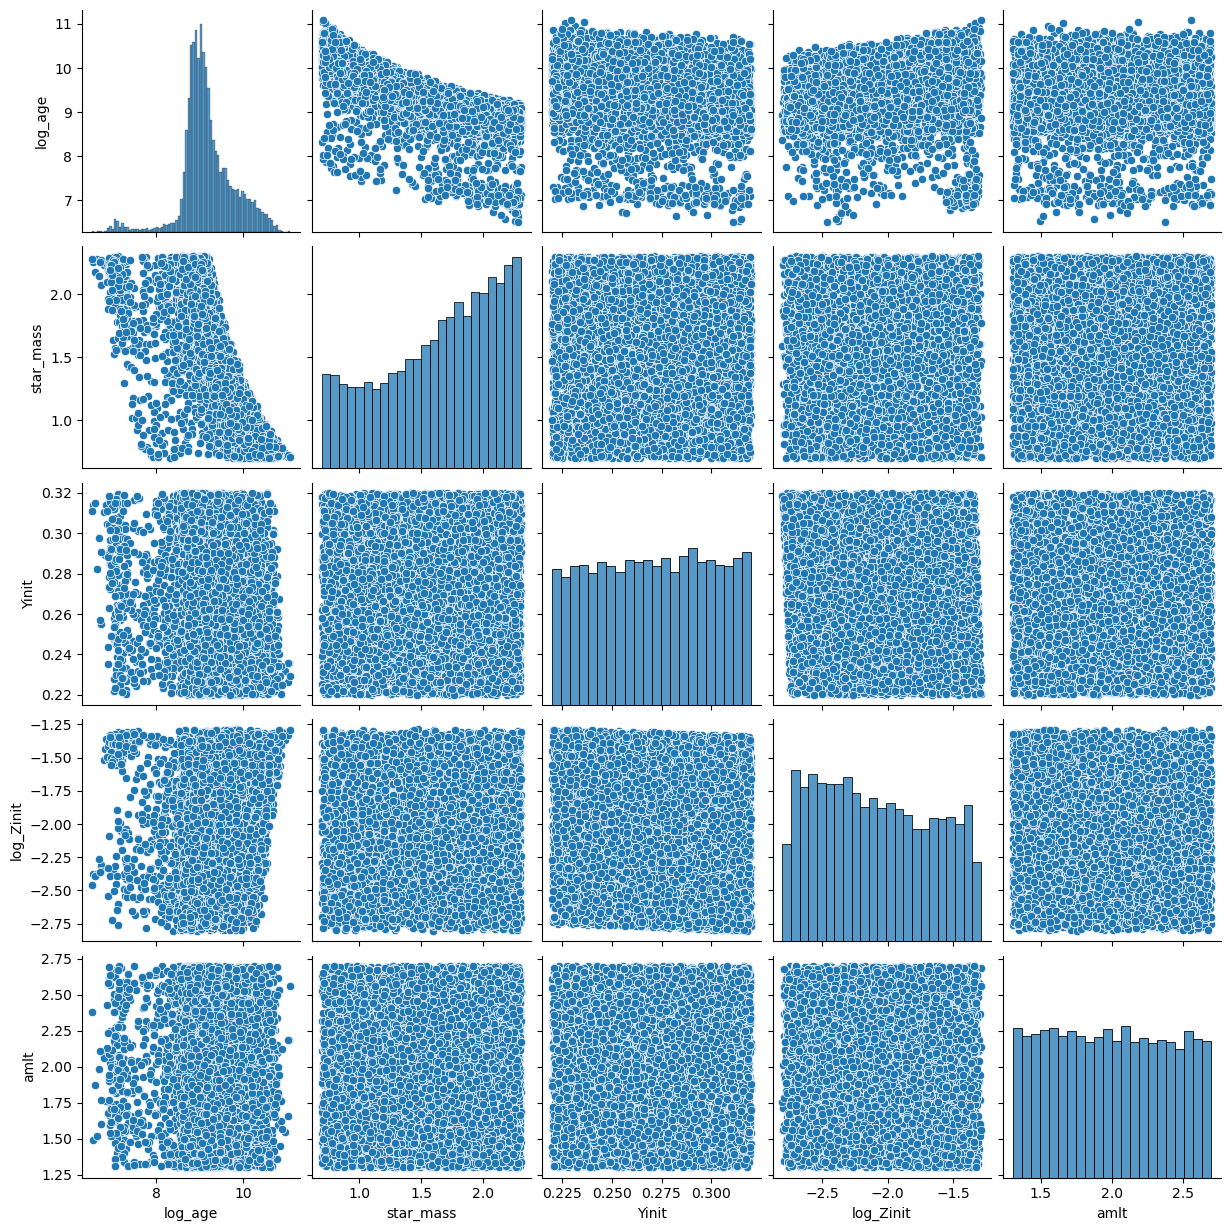

In [9]:
vars = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(grid.sample(10000), vars=vars);

The data needs some cleaning, there are low age patches.

In [10]:
grid["log_Teff"] = np.log10(grid.Teff)
grid["log_R"] = np.log10(grid.radius)
grid["log_Dnu"] = np.log10(grid.Dnu_freq_o)

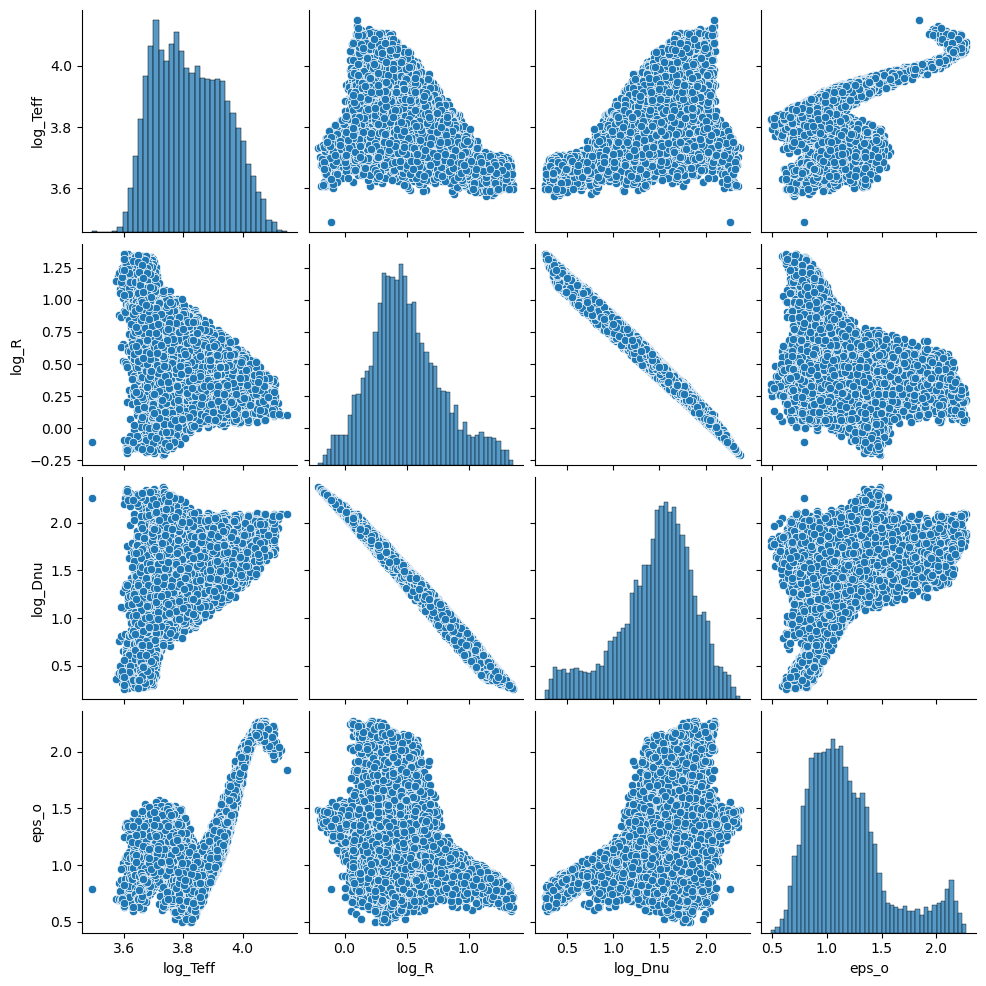

In [11]:
vars = ["log_Teff", "log_R", "log_Dnu", "eps_o"]
sns.pairplot(grid.sample(10000), vars=vars);

In [12]:
data = grid.dropna()
data.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius  ...    log_LHe  log_Lnuc  Dnu_freq_o     eps_o  \
0  2.220454e+07  0.893151  ... -45.291905  0.078416  148.565794  1.129515   
1  2.300916e+07  0.891027  ... -45.308912  0.077135  149.148739  1.131800   
2  2.397470e+07  0.890320  ... -45.328570  0.075916  149.362908  1.132830   
3  3.019433e+07  0.893682  ... -45.392646  0.075178  148.552167  1.130613   
4  3.259691e+07  0.894573  ... -45.402736  0.075810  148.331713  1.129892   

   delta_Pg  log_Zinit   log_age  log_Teff     log_R   log_Dnu  
0       0.0  -2.737812  7.346442  3.804991 -0.049075  2.171919  
1       0.0  -2.737812  7.361901  3.804638 -0.050109  2.173620  
2       0.0  -2.737812  7.379753  3.804397 -0.050454  2.174243  
3       0.0  -2.737812  7.479925  3.804236 -0.048817  2.171879  
4       0.0  -2.737812  7.513176  3.804239 -0.048384  2.171234  

[5 rows x 22 columns]

In [13]:
data["log_g"] = log_surface_gravity(data)
data["log_L"] = np.log10(luminosity(data))

In [14]:
with open("central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

In [15]:
data = data.drop(index=data[data.track.isin(bad)].index)

In [16]:
keys = ["log_age", "log_Teff", "log_L"]
primary, secondary = calculate_eep(data, keys)
data["phase"] = primary
data["EEP"] = secondary

In [17]:
data = data.drop(index=data[data.phase == -1].index)
data

track  star  star_mass     Yinit     Zinit      amlt  fov_core  \
4         7000     5    0.92329  0.279311  0.001829  1.608258       0.0   
5         7000     6    0.92329  0.279311  0.001829  1.608258       0.0   
6         7000     7    0.92329  0.279311  0.001829  1.608258       0.0   
7         7000     8    0.92329  0.279311  0.001829  1.608258       0.0   
8         7000     9    0.92329  0.279311  0.001829  1.608258       0.0   
...        ...   ...        ...       ...       ...       ...       ...   
6587233   4999   480    0.99087  0.316689  0.036025  1.923737       0.0   
6587234   4999   481    0.99087  0.316689  0.036025  1.923737       0.0   
6587235   4999   482    0.99087  0.316689  0.036025  1.923737       0.0   
6587236   4999   483    0.99087  0.316689  0.036025  1.923737       0.0   
6587237   4999   484    0.99087  0.316689  0.036025  1.923737       0.0   

         fov_shell      star_age     radius  ...    log_age  log_Teff  \
4         0.006041  3.259691e+07   0.894573  ...   7.513176  3.804239   
5         0.006041  3.548000e+07   0.895385  ...   7.549984  3.804235   
6         0.006041  4.309136e+07   0.896934  ...   7.634390  3.804211   
7         0.006041  5.405171e+07   0.898494  ...   7.732809  3.804184   
8         0.006041  6.983463e+07   0.900101  ...   7.844071  3.804177   
...            ...           ...        ...  ...        ...       ...   
6587233   0.006041  1.446116e+10  11.974001  ...  10.160203  3.622522   
6587234   0.006041  1.446395e+10  12.438793  ...  10.160287  3.620797   
6587235   0.006041  1.446496e+10  12.619153  ...  10.160317  3.620149   
6587236   0.006041  1.446593e+10  12.798060  ...  10.160346  3.619526   
6587237   0.006041  1.446687e+10  12.979214  ...  10.160375  3.618881   

            log_R   log_Dnu     log_g     log_L   delta_X     f_nuc  phase  \
4       -0.048384  2.171234  4.500174  0.074879  0.001608  1.002145      0   
5       -0.047990  2.170650  4.499387  0.075651  0.001875  1.001741      0   
6       -0.047240  2.169543  4.497885  0.077058  0.002592  1.001313      0   
7       -0.046485  2.168433  4.496376  0.078459  0.003644  1.000889      0   
8       -0.045709  2.167280  4.494823  0.079984  0.005195  1.000489      0   
...           ...       ...       ...       ...       ...       ...    ...   
6587233  1.078239  0.496672  2.277606  1.601259  0.647286  0.994609      3   
6587234  1.094778  0.471924  2.244528  1.627438  0.647286  0.994784      3   
6587235  1.101030  0.462585  2.232024  1.637351  0.647286  0.994722      3   
6587236  1.107144  0.453453  2.219796  1.647086  0.647286  0.994695      3   
6587237  1.113248  0.444344  2.207588  1.656715  0.647286  0.994695      3   

              EEP  
4        0.000000  
5        0.017941  
6        0.042945  
7        0.069534  
8        0.097459  
...           ...  
6587233  3.969520  
6587234  3.977782  
6587235  3.983385  
6587236  3.988946  
6587237  3.994484  

[6228873 rows x 28 columns]

In [18]:
data.star_mass.unique()

array([0.92329, 1.72329, 2.12329, ..., 2.19087, 1.79087, 0.99087])

<Axes: ylabel='Frequency'>

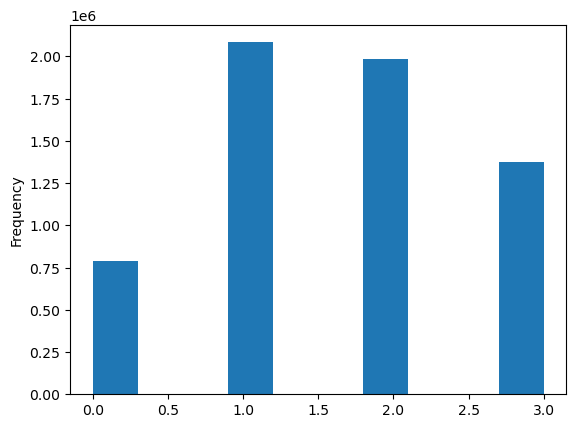

In [19]:
data.phase.plot(kind="hist")

In [20]:
ts = grid.track.sample(50)
mask = grid.track.isin(ts)

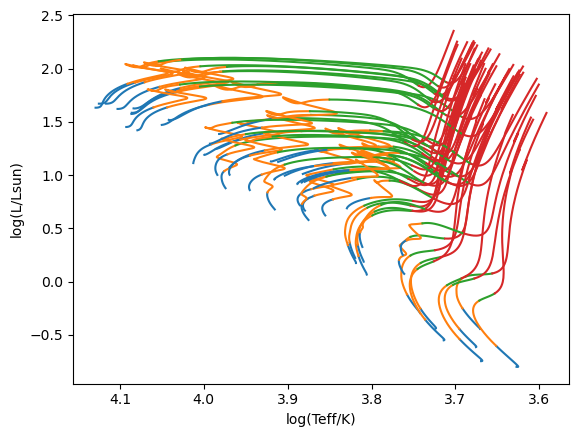

In [21]:
fig, ax = plt.subplots()

for idx, group in data.loc[mask].groupby(["track", "phase"], sort=False):
    label = None
    c = "gray" if idx[1] == -1 else f"C{idx[1]}"
    ax = group.plot(x="log_Teff", y="log_L", c=c, ax=ax, label=label)
#     ax.text(group.Teff.iloc[0], group.luminosity.iloc[0], idx[0])

ax.invert_xaxis()
# ax.invert_yaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")
# ax.legend(title="M, Yinit, Zinit, amlt")
ax.get_legend().remove()

In [22]:
features = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
labels = ["log_Teff", "log_R", "log_Dnu"]

In [23]:
data[features+labels].to_csv("/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.csv", index=False)

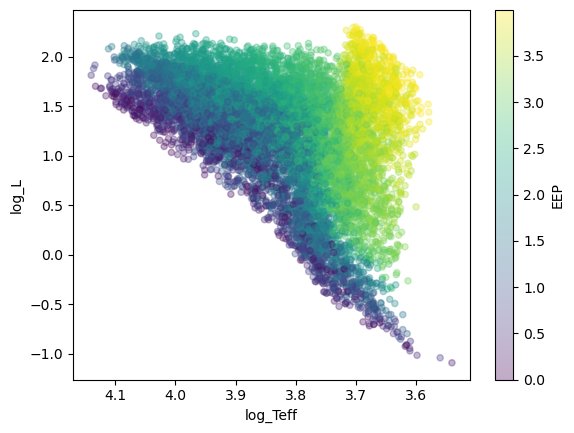

In [24]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="EEP", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

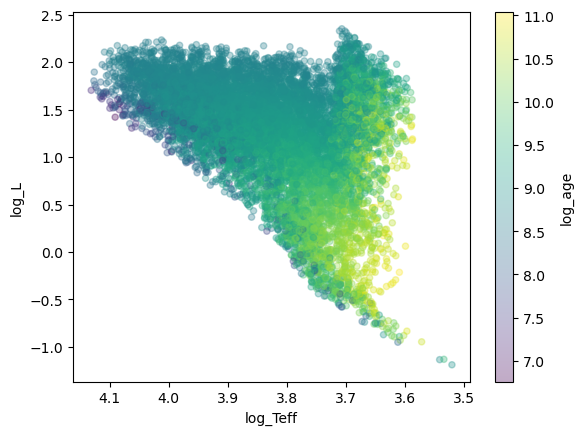

In [25]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="log_age", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

In [26]:
data["kron"] = data["star_age"] * data["star_mass"]**3.2
data["log_kron"] = np.log10(data["kron"])

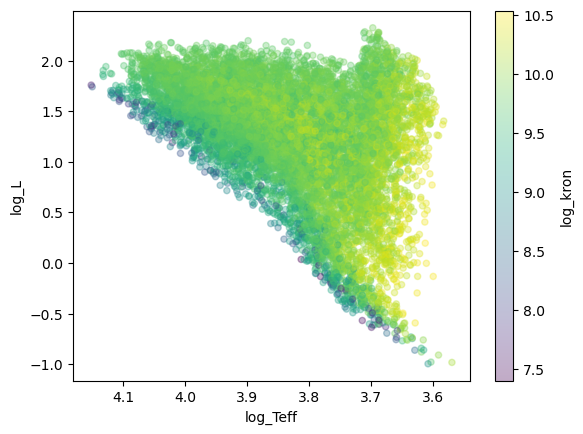

In [27]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="log_kron", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

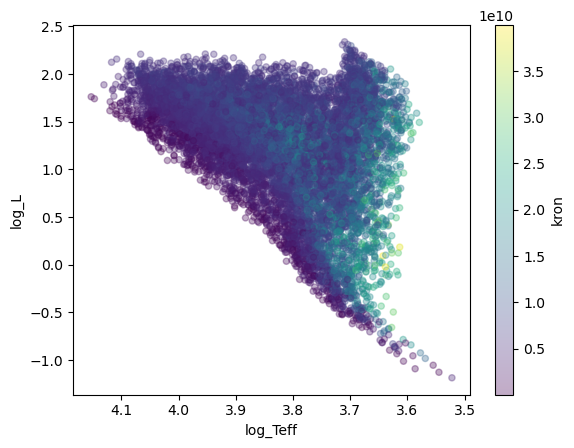

In [30]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="kron", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

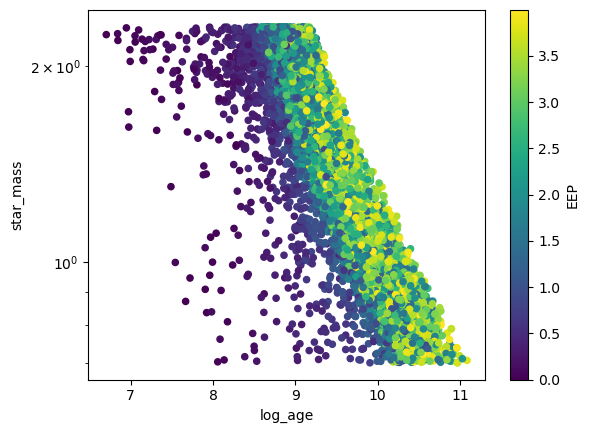

In [45]:
sample = data.sample(10000)
ax = sample.plot(x="log_age", y="star_mass", kind="scatter", c="EEP")
ax.set_yscale("log")

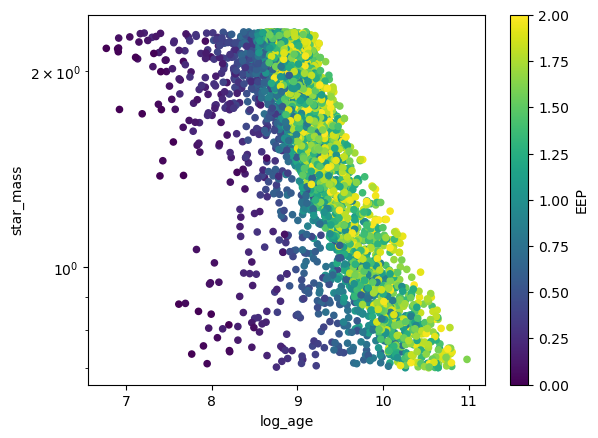

In [43]:
sample = data.sample(10000)
mask = sample["EEP"] <= 2
ax = sample[mask].plot(x="log_age", y="star_mass", kind="scatter", c="EEP")
ax.set_yscale("log")

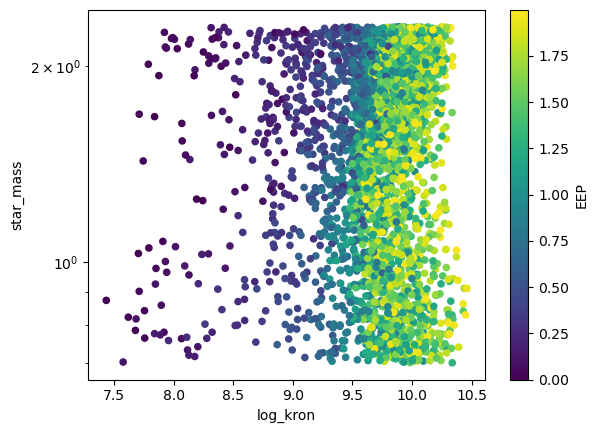

In [55]:
sample = data.sample(10000)
mask = sample["EEP"] < 2
ax = sample[mask].plot(x="log_kron", y="star_mass", kind="scatter", c="EEP")
ax.set_yscale("log")

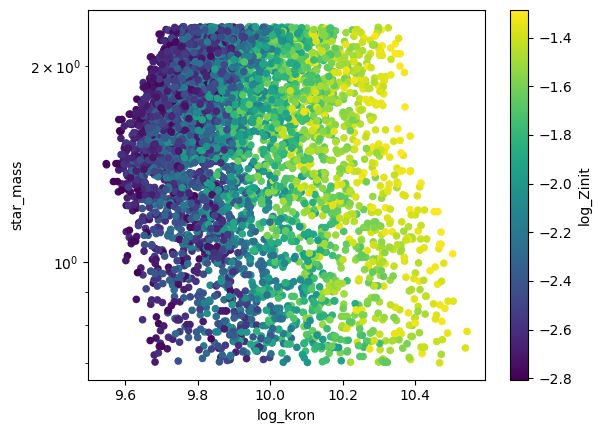

In [57]:
sample = data.sample(10000)
mask = sample["EEP"] > 2
ax = sample[mask].plot(x="log_kron", y="star_mass", kind="scatter", c="log_Zinit")
ax.set_yscale("log")

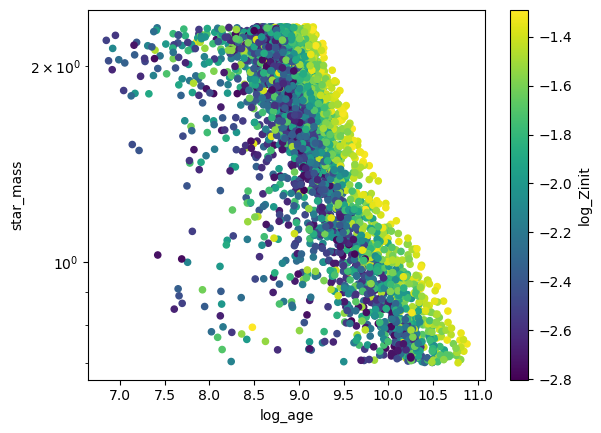

In [51]:
sample = data.sample(10000)
mask = sample["EEP"] <= 2
ax = sample[mask].plot(x="log_age", y="star_mass", kind="scatter", c="log_Zinit")
ax.set_yscale("log")

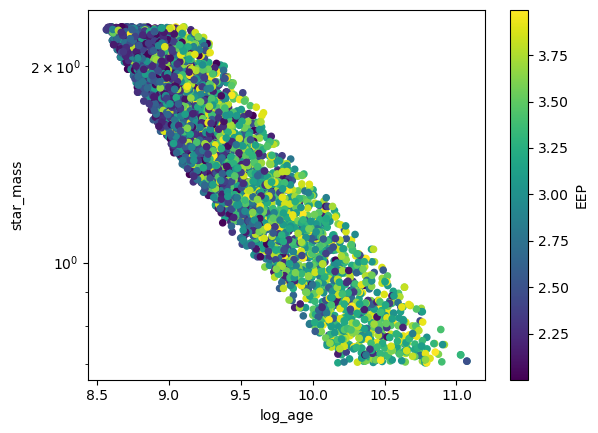

In [44]:
sample = data.sample(10000)
mask = sample["EEP"] > 2
ax = sample[mask].plot(x="log_age", y="star_mass", kind="scatter", c="EEP")
ax.set_yscale("log")

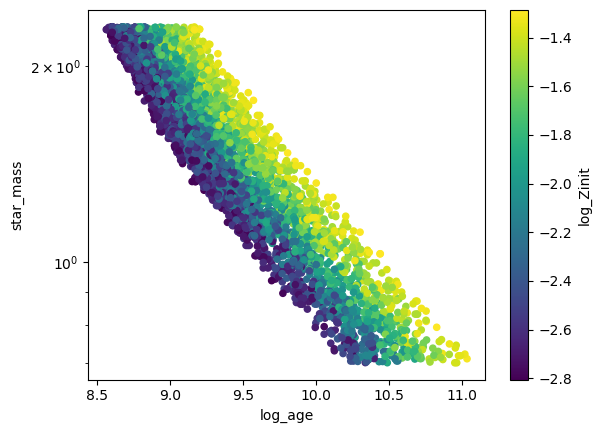

In [50]:
sample = data.sample(10000)
mask = sample["EEP"] > 2
ax = sample[mask].plot(x="log_age", y="star_mass", kind="scatter", c="log_Zinit")
ax.set_yscale("log")

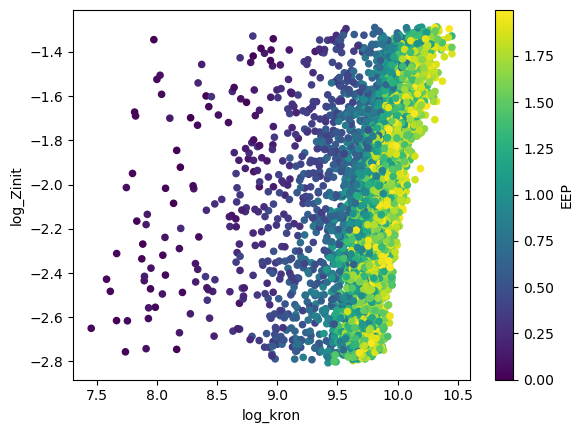

In [59]:
sample = data.sample(10000)
mask = sample["EEP"] < 2
ax = sample[mask].plot(x="log_kron", y="log_Zinit", kind="scatter", c="EEP")

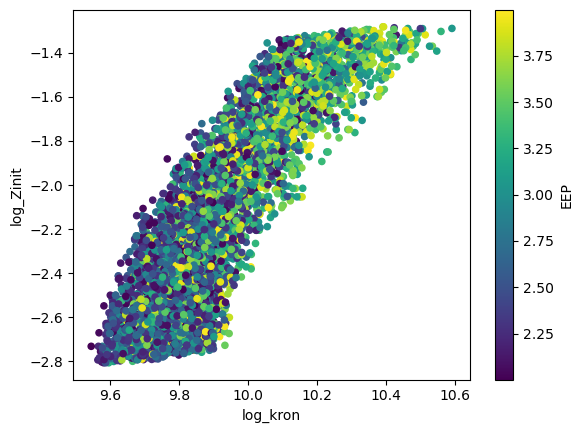

In [62]:
sample = data.sample(10000)
mask = sample["EEP"] > 2
ax = sample[mask].plot(x="log_kron", y="log_Zinit", kind="scatter", c="EEP")

In [41]:
rstate = 0
train = data.sample(frac=0.8, random_state=rstate)
test = data.drop(index=train.index)

In [42]:
# features = ["log_kron", "star_mass", "Yinit", "log_Zinit", "amlt"]
# sns.pairplot(train.sample(10000), vars=features);

In [43]:
# labels = ["log_Teff", "log_R", "log_Dnu"]
# sns.pairplot(train.sample(10000), vars=labels);

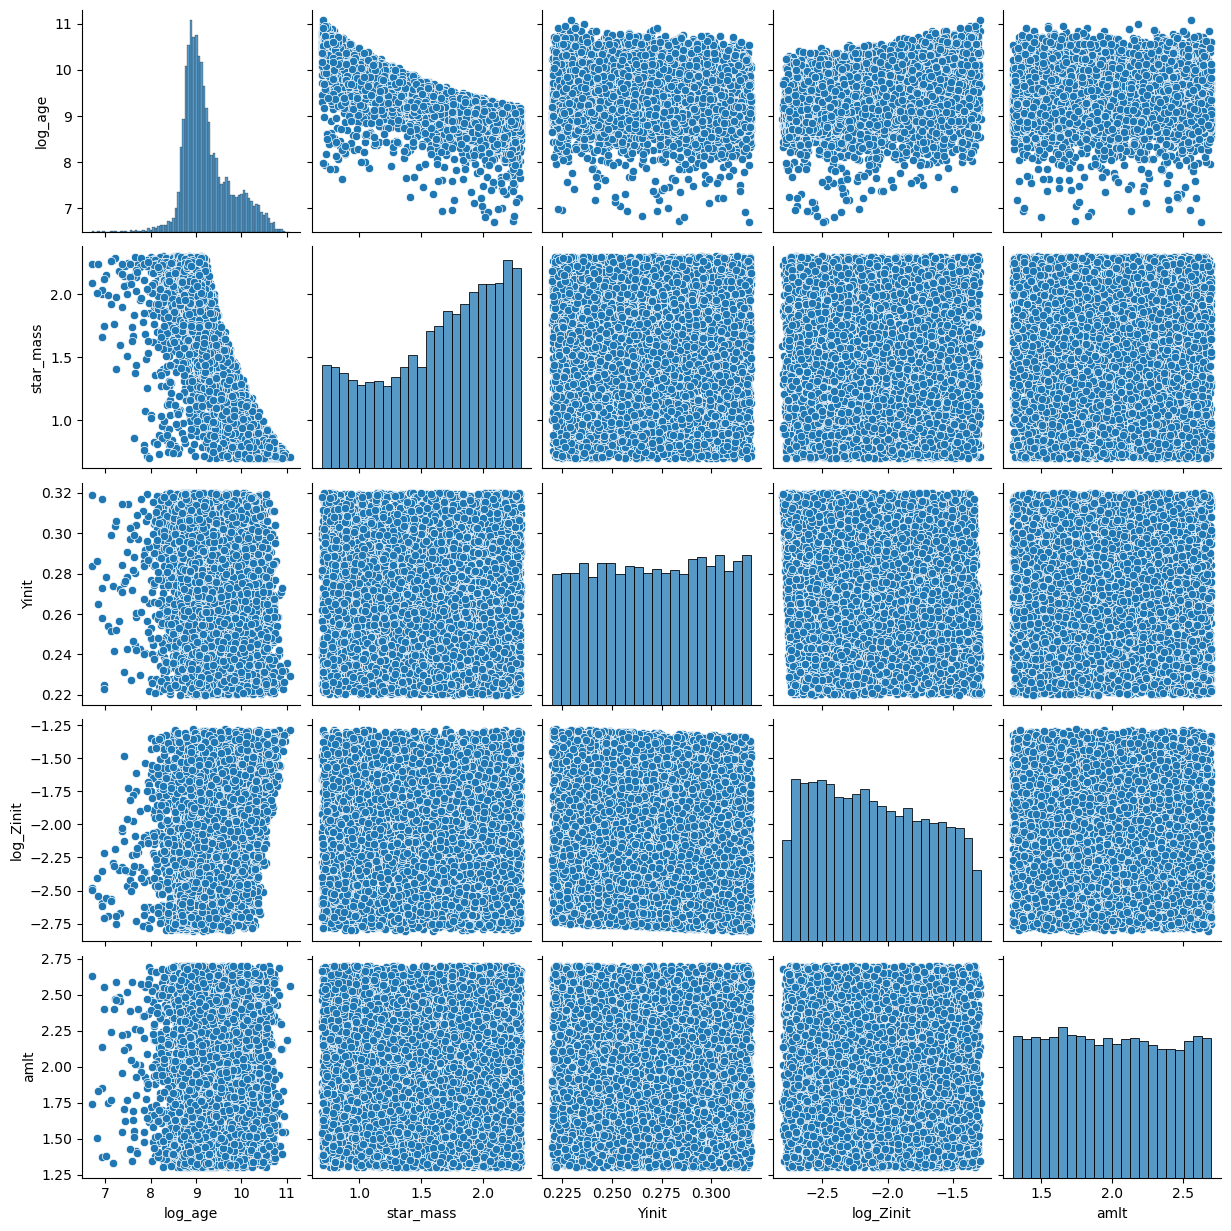

In [44]:
features = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(train.sample(10000), vars=features);

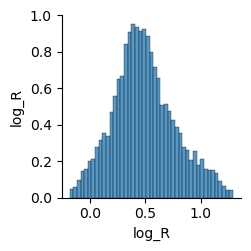

In [45]:
labels = ["log_R"]
sns.pairplot(train.sample(10000), vars=labels);

In [46]:
train_features = train[features].astype(np.float32).copy()
test_features = test[features].astype(np.float32).copy()

train_labels = train[labels].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

In [47]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features), batch_size=len(train_features))

2023-10-10 14:58:46.209215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18370 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-10-10 14:58:46.209797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18446 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


In [48]:
label_offset = train_labels.mean().to_numpy()
label_scale = train_labels.std().to_numpy()

rescaler = layers.Rescaling(label_scale, offset=label_offset)

In [49]:
num_features = len(features)
num_labels = len(labels)

In [69]:
2**6

64

In [93]:
class HyperModel(kt.HyperModel):
    def __init__(self, *args, max_iter=50000, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_iter = max_iter
        self.batch_size = None
        self.shuffle = None

    def build(self, hp):
#         self.batch_size = hp.Choice("batch_size", values=[2**i for i in range(9, 18, 2)])
        self.batch_size = 64
#         self.shuffle = hp.Boolean("shuffle")
        self.shuffle = False

#         units = hp.Choice('units_per_layer', values=[2**i for i in range(5, 10)])
        units = 256
#         num_layers = hp.Int("hidden_layers", min_value=2, max_value=8, step=1)
        num_layers = 8
        activation = "relu"
        
        model = tf.keras.Sequential(
            [normalizer] +
            [layers.Dense(units, activation) for _ in range(num_layers)] +
            [layers.Dense(num_labels), rescaler]
        )

#         learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        learning_rate = 1e-2
        opt = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
        loss = 'mean_squared_error'

        model.compile(opt, loss=loss)
        return model

    def fit(self, hp, model, x, y, stop_early=True, monitor="val_loss", **kwargs):
#         batch_size = hp.Choice("batch_size", values=[2**i for i in range(8, 19, 2)])
        validation_split = kwargs.pop("validation_split", 0.0)
        epochs = kwargs.pop(
            "epochs",
            int(self.max_iter * self.batch_size / (1 - validation_split) / x.shape[0]) + 1
        )
        
        cbs = kwargs.pop("callbacks", [])
        if stop_early and not any(isinstance(cb, callbacks.EarlyStopping) for cb in cbs):
            patience = max(3, int(0.05*epochs))
            early_stopping = callbacks.EarlyStopping(monitor=monitor, patience=patience)
            cbs.append(early_stopping)

#         shuffle = hp.Boolean("shuffle")
        return model.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=self.batch_size,
            validation_split=validation_split,
            shuffle=self.shuffle,
            callbacks=cbs,
            **kwargs,
        )

In [94]:
hypermodel = HyperModel()

In [95]:
directory = '/mnt/data-storage/stellar-emulator/tuning'
project_name = datetime.now().strftime("%Y%m%d-%H%M%S")

In [96]:
tuner = kt.BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=1,
    directory=directory,
#     overwrite=True,
    project_name=project_name,
)

In [97]:
tboard = callbacks.TensorBoard(f'/mnt/data-storage/stellar-emulator/tuning/{project_name}/logs')

In [98]:
tuner.search(
    train_features,
    train_labels,
    validation_split=0.2,
    callbacks=[tboard],
    stop_early=False,
)

Trial 1 Complete [00h 04m 55s]
val_loss: 0.008099356666207314

Best val_loss So Far: 0.008099356666207314
Total elapsed time: 00h 04m 55s
INFO:tensorflow:Oracle triggered exit


In [99]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]  # <-- choose 'best'
best_model = tuner.hypermodel.build(best_hp)

In [100]:
# trial_dir = tuner.get_trial_dir(19)
# with open(os.path.join(trial_dir, "trial.json")) as file:
#     d = json.loads(file.read())
# best_hp = kt.HyperParameters.from_config(d["hyperparameters"])
# best_model = tuner.hypermodel.build(best_hp)
# best_hp.values

In [ ]:
history = hypermodel.fit(
    best_hp,
    best_model,
    train_features, 
    train_labels, 
    stop_early=False,
    epochs=5,
)

Epoch 1/5
77861/77861 [==============================] - 319s 4ms/step - loss: 0.0097
Epoch 2/5
77861/77861 [==============================] - 309s 4ms/step - loss: 0.0054
Epoch 3/5
 1642/77861 [..............................] - ETA: 5:12 - loss: 0.0051

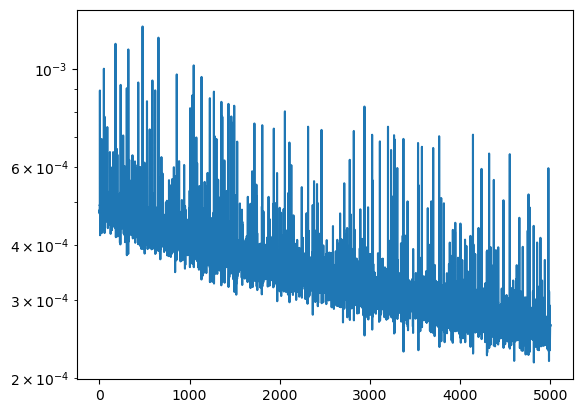

In [73]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history["loss"]);
ax.set_yscale("log")

In [74]:
num_points = 201
example_features = np.stack([
    np.linspace(7, 9.6, num_points),
    np.ones(num_points) * 1.0,
    np.ones(num_points) * 0.26,
    np.ones(num_points) * -2,
    np.ones(num_points) * 2,
], axis=-1)

example_labels = best_model(example_features).numpy()

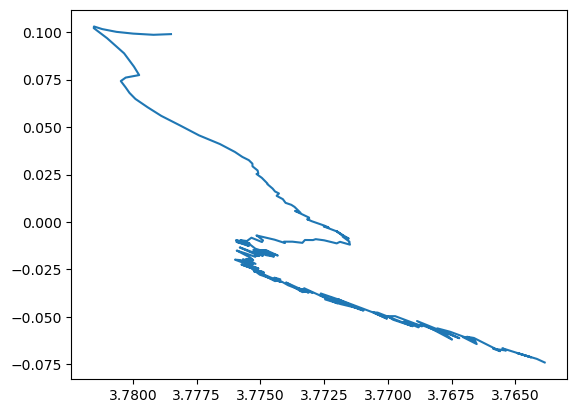

In [75]:
fig, ax = plt.subplots()


log_L = 2 * example_labels[:, 1] + 4 * (example_labels[:, 0] - np.log10(5772.))
ax.plot(example_labels[:, 0], log_L)
ax.invert_xaxis()

In [78]:
train_pred = best_model(train_features)
log_error = train_labels - train_pred.numpy()

Text(0, 0.5, 'log(L/Lsun)')

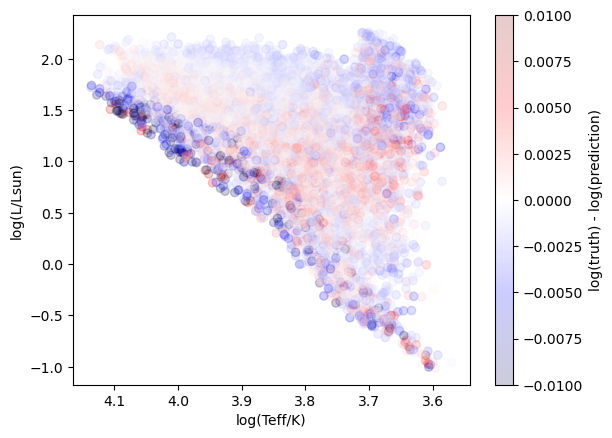

In [79]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.01, vmax=0.01)
fig.colorbar(s, label="log(truth) - log(prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

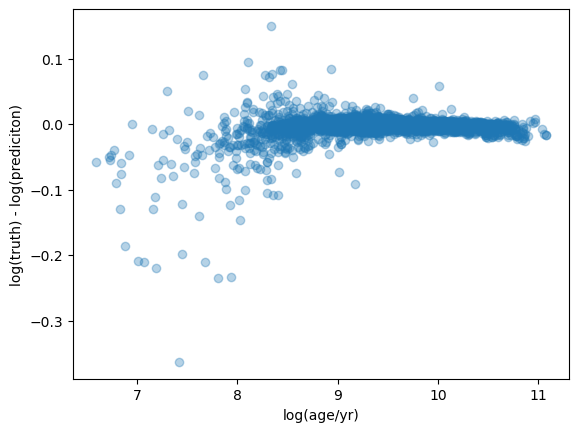

In [80]:
key = "log_age"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(age/yr)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

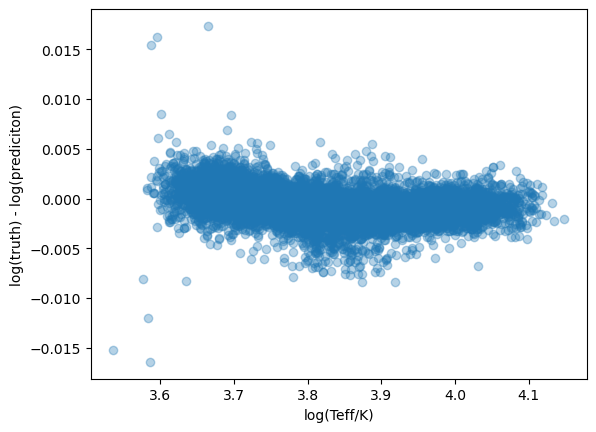

In [81]:
key = "log_Teff"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

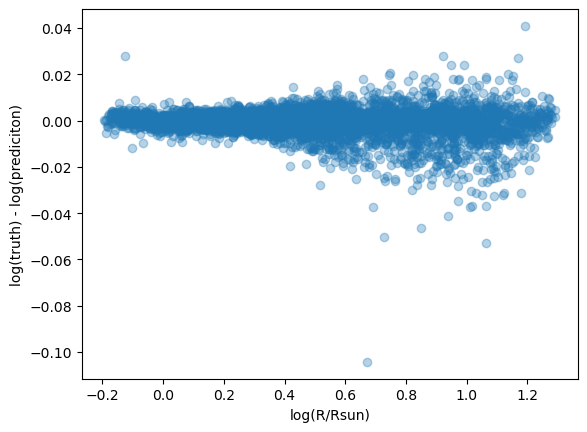

In [82]:
key = "log_R"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(R/Rsun)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

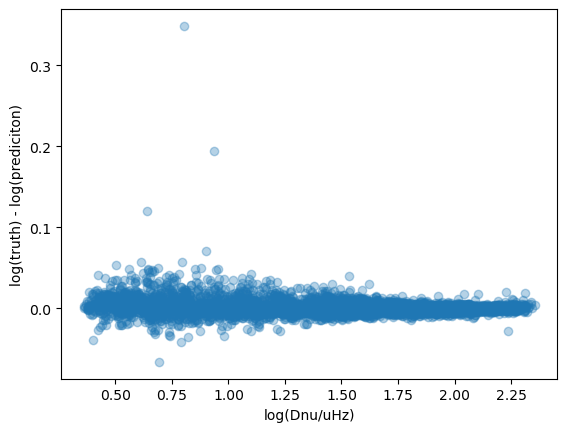

In [84]:
key = "log_Dnu"
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(Dnu/uHz)")
ax.set_ylabel("log(truth) - log(prediciton)")

In [88]:
train_pred = pd.DataFrame(train_pred, index=train.index, columns=["log_age", "log_Teff", "log_R", "log_Dnu"])
train_pred["log_L"] = 2 * train_pred["log_R"] + 4 * (train_pred["log_Teff"] - np.log10(5772.))

In [89]:
error = 10**train_labels - 10**train_pred

In [90]:
error.std()

log_Dnu     4.446557e-01
log_L                NaN
log_R       8.597057e-02
log_Teff    2.556183e+01
log_age     1.765172e+08
dtype: float64

In [91]:
(10**train["log_L"] - 10**train_pred["log_L"]).std()

0.8184800403186487

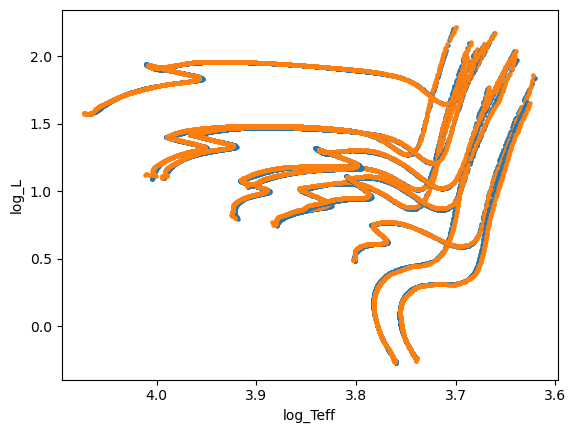

In [92]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

ax.invert_xaxis();

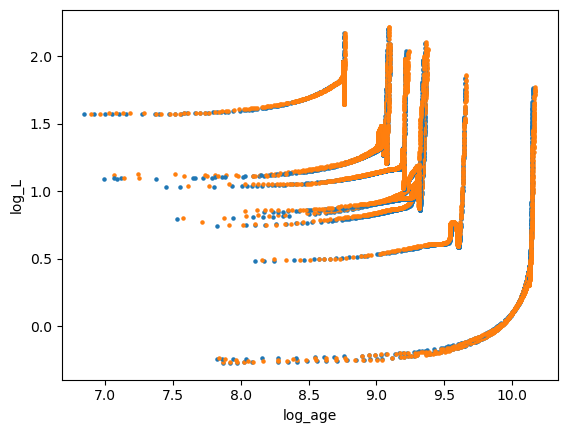

In [93]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_age", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_age", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

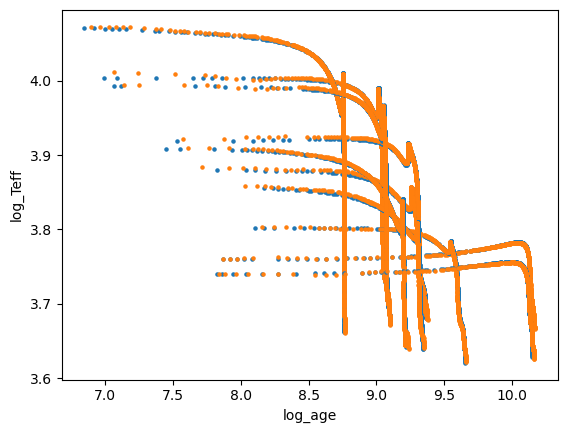

In [94]:
fig, ax = plt.subplots()
for ti in train.track.sample(10, random_state=0):
    mask = train.track == ti
    ax = train.loc[mask].plot(x="log_age", y="log_Teff", kind="scatter", marker=".", ax=ax)
    ax = train_pred.loc[mask].plot(x="log_age", y="log_Teff", kind="scatter", c="C1", marker=".", ax=ax)

In [95]:
filepath = os.path.join(directory, project_name, "best", "model.tf")
best_model.save(filepath)

INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20230627-173049/best/model.tf/assets


In [110]:
import json

In [115]:
history_dict = dict(
    history=history.history,
    params=history.params,
    epoch=history.epoch,
)

In [116]:
with open("test.json", "w") as file:
    s = json.dumps(history_dict)
    file.write(s)

In [ ]:
callbacks.ModelCheckpoint()

In [ ]:
callbacks.EarlyStopping()